# Analisis Data COVID-19 - Python Jupyter Notebook
---
## Pendahuluan
Covid19 adalah pandemi yang sudah mewabah ke seluruh dunia. Sebagian besar negara-negara di dunia sudah terjangkit. Penanganan tiap-tiap negara pun berbeda, sesuai dengan kebijakan pemerintah. Hal ini mengakibatkan perbedaan trend kenaikan atau penurunan kasus covid berbeda-beda tiap negara.

Pada kasus kali ini, data covid-19 didapatkan dari salah satu opensource api yaitu [https://covid19-api.org/](https://covid19-api.org/).

## Library

- json
- numpy
- pandas
- requests

In [1]:
import json
import numpy as np
import pandas as pd
import requests

## Get Data From Api
fungsi __get_json__ dengan parameter __api_url__. fungsi ini akan mengembalikan value berupa python dictionary jika __status_code__ yang dihasilkan adalah 200. Jika tidak, maka value yang dikembalikan adalah __None__.

In [2]:
def get_json(api_url):
	response = requests.get(api_url)
	if response.status_code == 200:
		return json.loads(response.content.decode('utf-8'))
	else:
		return None

## Request API Covid-19
Untuk mendapatkan dataframe covid-19, gunakan fungsi ___pd.io.json.json_normalize___ dan panggil function yang sudah dibuat sebelumnya, yaitu function __get_json()__.

In [4]:
record_date = '2020-08-17'
covid_url = 'https://covid19-api.org/api/status?date='+record_date
df_covid_worldwide = pd.io.json.json_normalize(get_json(covid_url))

print(df_covid_worldwide.head())

country          last_update    cases  deaths  recovered
0      US  2020-08-16T23:27:50  5401167  170019    1833067
1      BR  2020-08-16T23:27:50  3340197  107852    2655017
2      IN  2020-08-16T23:27:50  2589682   49980    1862258
3      RU  2020-08-16T23:27:50   920719   15653     731444
4      ZA  2020-08-16T23:27:50   587345   11839     472377


## Merubah Format date
merubah format kolom 'last_update' menggunakan fungsi to_datetime dengan format YYYY-mm-dd HH:MM:SS. dan merubah bentuk datetime ke bentuk date dengan fungsi date() melalui fungsi lambda untuk mengubah setiap row data-nya

In [9]:
df_covid_worldwide['last_update'] = pd.to_datetime(df_covid_worldwide['last_update'], format='%Y-%m-%d %H:%M:%S')
df_covid_worldwide['last_update'] = df_covid_worldwide['last_update'].apply(lambda x: x.date())

## Request Data Countries

In [11]:
countries_url = 'https://covid19-api.org/api/countries'
df_countries = pd.io.json.json_normalize(get_json(countries_url))
df_countries = df_countries.rename(columns={'alpha2': 'country'})[['name','country']]

print(df_countries.head())

,name,country
0,Afghanistan,AF
1,Albania,AL
2,Algeria,DZ
3,Andorra,AD
4,Angola,AO


## Merge Data Covid-19 dan Countries
mapping data covid19 dan data country. menggunakan fungsi merge pada pandas untuk menggabungkan df_covid_worldwide dan df_countries.

In [15]:
df_covid_denormalized = pd.merge(df_covid_worldwide , df_countries, on='country')
print(df_covid_denormalized.head())

country last_update    cases  deaths  recovered                      name
0      US  2020-08-16  5401167  170019    1833067  United States of America
1      BR  2020-08-16  3340197  107852    2655017                    Brazil
2      IN  2020-08-16  2589682   49980    1862258                     India
3      RU  2020-08-16   920719   15653     731444        Russian Federation
4      ZA  2020-08-16   587345   11839     472377              South Africa


## Menghitung Fatality Ratio
kolom tambahan yaitu fatality_ratio, yang merupakan pembagian antara kolom deaths dan cases.

In [16]:
df_covid_denormalized['fatality_ratio'] = df_covid_denormalized['deaths'] / df_covid_denormalized['cases']

## Negara-negara dengan Fatality Ratio Tertinggi
top 20 negara dengan value kolom fatality_ratio tertinggi 

In [19]:
df_top_20_fatality_rate = df_covid_denormalized.sort_values(by='fatality_ratio', ascending=False).head(20)

## Visualisasi Negara dengan Fatality Ratio Tertinggi
visualisasikan negara-negara dengan kasus fatality rate tertinggi akibat covid-19 ini dapat dilakukan dengan menggunakan bar chart.

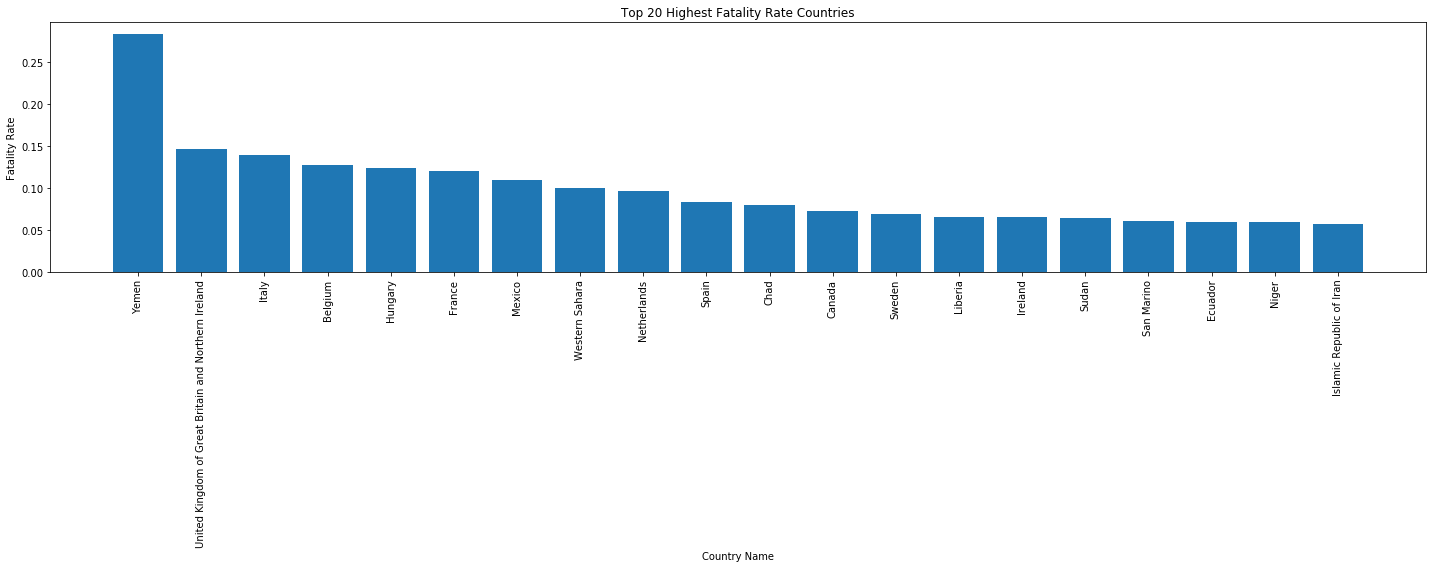

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 8))
x = df_top_20_fatality_rate['name']
y = df_top_20_fatality_rate['fatality_ratio']
plt.bar(x,y)
plt.xlabel('Country Name')
plt.ylabel('Fatality Rate')
plt.title('Top 20 Highest Fatality Rate Countries')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Menggabungkan Dataframe
membandingkan kasus covid19 di Indonesia (ID) dengan negara-negara tetangga, yaitu:

- MY -> Malaysia
- SG -> Singapure
- TH -> Thailand
- VN -> Vietnam

In [51]:
countries = ['ID','MY','SG','TH','VN']
i = 0
for country in countries:
    covid_timeline_url = 'https://covid19-api.org/api/timeline/'+country
    df_covid_timeline = pd.io.json.json_normalize(get_json(covid_timeline_url))
    df_covid_timeline['last_update'] = pd.to_datetime(df_covid_timeline['last_update'], format='%Y-%m-%dT%H:%M:%S')
    df_covid_timeline['last_update'] = df_covid_timeline['last_update'].apply(lambda x: x.date())
    if i==0:
        df_covid_timeline_merged = df_covid_timeline
    else:
        df_covid_timeline_merged = df_covid_timeline.append(df_covid_timeline_merged, ignore_index=True)
    i=i+1

print(df_covid_timeline_merged.head())

country last_update  cases  deaths  recovered
0      VN  2020-09-12   1060      35        902
1      VN  2020-09-11   1060      35        902
2      VN  2020-09-10   1059      35        893
3      VN  2020-09-09   1059      35        890
4      VN  2020-09-08   1054      35        868


## Merge Data Covid19 Dengan Data Country
df_covid_timeline_merged dengan df_countries dengan kolom country sebagai pivot.

In [60]:
df_covid_timeline_denormalized = pd.merge(df_covid_timeline_merged, df_countries, on='country')

## Visualisasi kasus Covid-19 dari Bulan Maret 2020


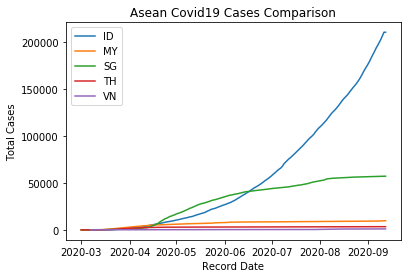

In [182]:
import datetime
import matplotlib.pyplot as plt

df_covid_timeline_denormalized = df_covid_timeline_denormalized[(df_covid_timeline_denormalized['last_update'] >= datetime.date(2020, 3, 1))]
plt.clf()
countries = ['ID','MY','SG','TH','VN']
for country in countries:
	country_data = df_covid_timeline_denormalized['country']==country
	x = df_covid_timeline_denormalized[country_data]['last_update']
	y = df_covid_timeline_denormalized[country_data]['cases']
	plt.plot(x, y, label = country)
    
plt.legend()
plt.xlabel('Record Date')
plt.ylabel('Total Cases')
plt.title('Asean Covid19 Cases Comparison')
plt.show()